In [5]:
%pip install tensorflow_probability

  Using cached cloudpickle-1.6.0-py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import tensorflow as tf
import math, os, sys
import matplotlib.pyplot as plt
import tensorflow_probability as tfp 

C:\Users\keypg\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\keypg\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\keypg\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
N = 10
STEPS = 250
LOSS = 'mse'
BATCH_SIZE = 32

dataset = np.load('dataset/all_data-preprocessed.npz')
features, labels = dataset['features'].astype('float32'), dataset['labels'].astype('float32')
train_test_split_factor = .8
validation_split_factor = .2
train_x, train_y, test_x, test_y = features[:math.floor(len(features)*train_test_split_factor)], labels[:math.floor(len(labels)*train_test_split_factor)], features[math.floor(len(features)*train_test_split_factor):], labels[math.floor(len(labels)*train_test_split_factor):]
train_x, test_x = np.expand_dims(train_x, axis=-1), np.expand_dims(test_x, axis=-1) # for use with TimeDistributed
input_shape = train_x.shape
#train_y, test_y = np.expand_dims(train_y, axis=1), np.expand_dims(test_y, axis=1) # for use with TimeDistributed
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(288, 1, 7, 1) (288, 7) (72, 1, 7, 1) (72, 7)


In [4]:
def build_model(loss, optimizer='adam'):
    layers = [
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(7, 3, padding='same', activation='relu', input_shape=input_shape[1:])),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(7, 3, padding='same', activation='relu', dilation_rate=2)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(14, 3, padding='same', activation='relu', dilation_rate=1)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(36, 3, padding='same', activation='relu', dilation_rate=1)),
        tf.keras.layers.Dense(70, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(7, activation='linear')
    ]
    model = tf.keras.models.Sequential(layers=layers)
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [5]:
def run_backpropagation(x_train, y_train, epochs=0):
    best_model = None
    best_score = float('inf')
    if epochs == 0:
        epochs = STEPS
    for i in range(N):
        model_s = build_model(LOSS)
        model_s.fit(
            x_train, y_train,
            epochs=epochs,
            batch_size=BATCH_SIZE,
            verbose=0
        )
        train_score = model_s.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=0)
        if train_score < best_score:
            best_model = model_s
            best_score = train_score
        return best_model

In [59]:
tf.convert_to_tensor(model_obj.evaluate(test_x,test_y,verbose=0), dtype=tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=63280.332>

In [58]:
tf.random.normal([7])[0].dtype.base_dtype

tf.float32

In [74]:
tf.enable_eager_execution()
population_size = 40 
# With an initial population and a multi-part state.
initial_population = (tf.random.normal(test_x.shape),
                    tf.random.normal(test_y.shape))
initial_position = (tf.constant(1.0), tf.constant(1.0))
model_obj = run_backpropagation(train_x, train_y, 1) # initilize weights

def de_objective(x, y):
    #return tf.convert_to_tensor(model_obj.evaluate(x, y, verbose=0), dtype=tf.float32)
    return tf.Variable(model_obj.evaluate(x, y, verbose=0), dtype=tf.float32)

#def easom_fn(x, y):
#    return -(tf.math.cos(x) * tf.math.cos(y) *
#         tf.math.exp(-(x-np.pi)**2 - (y-np.pi)**2))

de_optimizer = tfp.optimizer.differential_evolution_minimize(de_objective,
                                                            initial_population=initial_population,
                                                            initial_position=None,
                                                            population_size=population_size,
                                                            population_stddev=1.0,
                                                            max_iterations=100,
                                                            func_tolerance=0,
                                                            position_tolerance=1e-08,
                                                            differential_weight=0.5,
                                                            crossover_prob=0.9)
model_de = build_model(LOSS, de_optimizer)
model_de.fit(
    train_x, train_y,
    epochs=250,
    batch_size=BATCH_SIZE
)

AttributeError: module 'tensorflow' has no attribute 'enable_eager_execution'

In [7]:
# fit test sample into batch
max_samples_test_x = test_x.shape[0]
padd_time = 32 - (max_samples_test_x - max_samples_test_x//32*32)
test_x_fit_bs32 = test_x[64:]
for i in range(padd_time):
    test_x_fit_bs32 = np.concatenate((test_x_fit_bs32, np.expand_dims(test_x_fit_bs32[-1], axis=0)))
test_x_fit_bs32.shape
model_p.predict(test_x_fit_bs32)

array([[198.0694 , 198.64291, 203.3807 , 200.3389 , 203.87701, 199.9482 ,
        204.05898],
       [314.46463, 316.48914, 323.22443, 320.32175, 325.20148, 318.39246,
        325.0246 ],
       [321.1539 , 323.37744, 330.32767, 327.86972, 332.52335, 325.49854,
        332.2129 ],
       [413.7916 , 417.43658, 425.4994 , 423.06775, 428.74667, 419.71063,
        428.17868],
       [404.96997, 408.45245, 416.73325, 414.91205, 420.1315 , 411.09882,
        419.38306],
       [452.34897, 456.68878, 465.32364, 463.38516, 469.18484, 459.2108 ,
        468.40182],
       [464.1343 , 468.7425 , 477.78693, 476.56055, 482.0278 , 471.6446 ,
        481.01184],
       [454.89926, 459.3726 , 468.1775 , 466.69275, 472.20703, 462.09985,
        471.29816],
       [454.89926, 459.3726 , 468.1775 , 466.69275, 472.20703, 462.09985,
        471.29816],
       [454.89926, 459.3726 , 468.1775 , 466.69275, 472.20703, 462.09985,
        471.29816],
       [454.89926, 459.3726 , 468.1775 , 466.69275, 472.2070

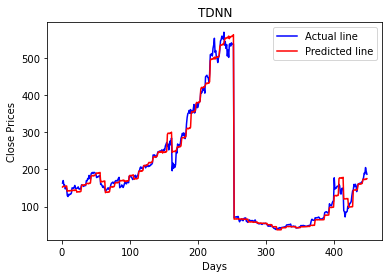

In [8]:
pred = model_s.predict(test_x[:64])
close_pred = np.reshape(pred, (-1, 1))
test_y_reshape = np.reshape(test_y[:64], (-1, 1))
days = np.arange(1, len(test_y_reshape)+1)
plt.plot(days, test_y_reshape, 'b', label='Actual line')
plt.plot(days, close_pred, 'r', label='Predicted line')
plt.title('TDNN')
plt.xlabel('Days')
plt.ylabel('Close Prices')
plt.legend()
plt.show()

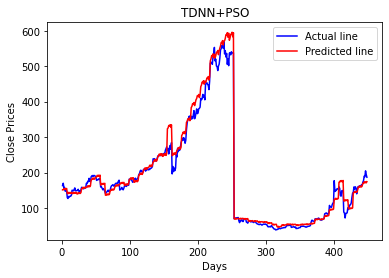

In [9]:
pred = model_p.predict(test_x[:64])
close_pred = np.reshape(pred, (-1, 1))
test_y_reshape = np.reshape(test_y[:64], (-1, 1))
days = np.arange(1, len(test_y_reshape)+1)
plt.plot(days, test_y_reshape, 'b', label='Actual line')
plt.plot(days, close_pred, 'r', label='Predicted line')
plt.title('TDNN+PSO')
plt.xlabel('Days')
plt.ylabel('Close Prices')
plt.legend()
plt.show()

In [10]:
model_s.save('weights/tdnn.h5')
model_s.save_weights('weights/tdnn_weight_only.h5')
model_p.save('weights/tdnnpso.h5')
model_p.save_weights('weights/tdnnpso_weight_only.h5')